In [1]:
using Flux, Statistics
using Flux: onehotbatch, onecold, crossentropy, throttle, params 
using Base.Iterators: repeated, partition
using Printf, BSON
using CSV
using DataFrames
using Tables
using Random
using Plots

In [2]:
original_dat = CSV.read("../processed-data/otu-yield-per-plant.csv", header=true, DataFrame)
generated_dat = CSV.read("../processed-data/generated-data.csv", header=false, DataFrame)

original = Matrix(original_dat)
generated = Matrix(generated_dat)
full_data = vcat(original, generated)

otu = full_data[:,2:60]
label = full_data[:,62]

percentage = [(i, count(==(i), label)) for i in unique(label)]
println("Number of low-yield samples: ", percentage[1][2], "; Number of high-yield samples: ", percentage[2][2])

Number of low-yield samples: 222; Number of high-yield samples: 222


In [3]:
function make_fold(data, idx)
    # The 2D array for data in each folder.The dimension is 22*2394
    data_batch = Array{Float32, 2}(undef, length(idx), length(data[1,:]))
    # Add all data for this folder into the batch
    for i in 1:length(idx)
        data_batch[i,:] = data[idx[i],:]
    end
    return (data_batch', data_batch')
end

make_fold (generic function with 1 method)

In [4]:
function k_fold_partition(otu_batch)
    # partition the whole dataset into 10 folds
    fold_idx = partition(1:length(otu_batch[:,1]), length(otu_batch[:,1])÷10+1)
    # call make_fold and store the 10 folds
    whole_set = [make_fold(otu_batch, i) for i in fold_idx]

    return whole_set
end

k_fold_partition (generic function with 1 method)

In [5]:
model = Chain(
    Chain(
    Dense(59, 38, σ),
    Dense(38, 14, σ),
    Dense(14, 5)),
    Chain(
    Dense(5, 14, σ),
    Dense(14, 38, σ),
    Dense(38, 59, σ))
)

Chain(
  Chain(
    Dense(59 => 38, σ),                 # 2_280 parameters
    Dense(38 => 14, σ),                 # 546 parameters
    Dense(14 => 5),                     # 75 parameters
  ),
  Chain(
    Dense(5 => 14, σ),                  # 84 parameters
    Dense(14 => 38, σ),                 # 570 parameters
    Dense(38 => 59, σ),                 # 2_301 parameters
  ),
)                   # Total: 12 arrays, 5_856 parameters, 23.812 KiB.

In [6]:
function train(whole_set) 
    uni_best = 1
    # loop through all 10 folders
    for k in 1:10 
        println("Start training on the ", k, "th fold...")
        # set the training set and the testing set
        train_set = whole_set[Not(k)]
        test_set = whole_set[k]
        # reset all the parameters
        Flux.loadparams!(model, map(p -> p .= randn.(), Flux.params(model)))
        # here the loss function is MSE, I also tried cross-entropy. 
        # I'll write down the result for both in the conclusion section
        loss(x, y) = Flux.Losses.mse(model(x),y)
        # record the number of continuous epoches that the loss increases
        loss_inc = 0
        # the loss of the current epoch for the validation set
        val_loss = 1000
        # the lowest loss so far in this fold
        best_loss = 1000

        # the optimizer is Adam with learning rate of 0.001
        opt = ADAM(0.001)
        # the maximum epoch is 200
        for epoch_idx in 1:20000
            # train the network
            Flux.train!(loss, params(model), train_set, opt)
            # calculate the validation loss for this epoch
            val_loss = loss(test_set...)
            # if the loss increases, increment the counter
            if val_loss >= best_loss 
                loss_inc += 1
            else
                # if not, then set the current loss as lowest
                best_loss = val_loss
                loss_inc = 0
                if best_loss < uni_best
                    uni_best = best_loss
                    BSON.@save "AENN.bson" model epoch_idx uni_best
                end
            end
            # loss has increased for 5 continuous epoch, exit to prevent overfitting
            if loss_inc >= 10 && opt.eta > 1e-10
                opt.eta /= 10.0
                loss_inc = 0
            end
            
            if loss_inc >= 10
                println("Force exit to prevent overfit at epoch: ", epoch_idx)
                break
            end
        end
        println("Finished training the ", k, "th folder..." )
        println("The final validation loss is: ", best_loss)
        println("------------------------------------")
    end
    return uni_best
end

train (generic function with 1 method)

In [7]:
otu = otu[shuffle(1:size(otu)[1]), :]
whole_set = k_fold_partition(otu)
# reset the parameter of the model to get the untrained loss, just as a reference
Flux.loadparams!(model, map(p -> p .= randn.(), Flux.params(model)))
loss(x, y) = Flux.Losses.mse(model(x),y)
print("The untrained loss for each folder is: ")
for i in 1:10
    print(loss(whole_set[i]...), ", ")
end

# Start the training
println("Start training...")
best_loss = train(whole_set)
println("The lowest loss among all models is: ", best_loss)

The untrained loss for each folder is: 0.37303725, 0.37336835, 0.3731186, 0.37356174, 0.37316832, 0.37323695, 0.3739049, 0.37309995, 0.37308326, 0.37340343, Start training...
Start training on the 1th fold...
Force exit to prevent overfit at epoch: 4391
Finished training the 1th folder...
The final validation loss is: 9.391888e-6
------------------------------------
Start training on the 2th fold...
Force exit to prevent overfit at epoch: 2368
Finished training the 2th folder...
The final validation loss is: 1.4540626e-5
------------------------------------
Start training on the 3th fold...
Finished training the 3th folder...
The final validation loss is: 8.353331e-6
------------------------------------
Start training on the 4th fold...
Force exit to prevent overfit at epoch: 3607
Finished training the 4th folder...
The final validation loss is: 1.0176414e-5
------------------------------------
Start training on the 5th fold...
Force exit to prevent overfit at epoch: 8071
Finished trai

In [9]:
BSON.@load "AENN.bson" model

In [10]:
rand_num = zeros(6)
while true
    rand_num = rand((1:size(otu)[1]),6)
    if length(unique(rand_num)) == 6
        break
    end
end

a_x = otu[rand_num[1],:]
a_y = model(a_x)
b_x = otu[rand_num[2],:]
b_y = model(b_x)
c_x = otu[rand_num[3],:]
c_y = model(c_x)
d_x = otu[rand_num[4],:]
d_y = model(d_x)
e_x = otu[rand_num[5],:]
e_y = model(e_x)
f_x = otu[rand_num[6],:]
f_y = model(f_x)

whole = hcat(a_x, a_y, b_x, b_y, c_x, c_y, d_x, d_y, e_x, e_y, f_x, f_y)
CSV.write("../processed-data/plot.csv",  Tables.table(whole), writeheader=false)

"../processed-data/plot.csv"

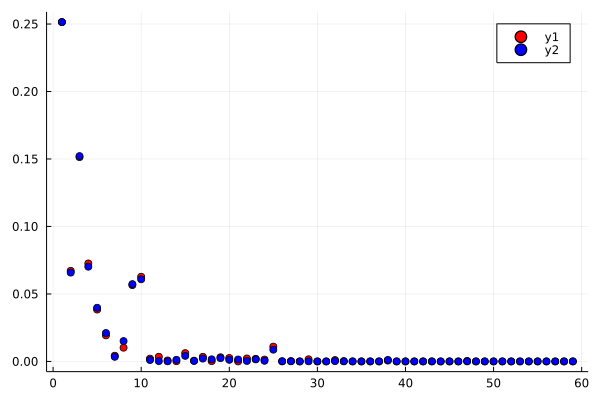

In [19]:
Plots.scatter(a_x; color="red", clim=(0, 1))
Plots.scatter!(a_y; color="blue", clim=(0, 1))

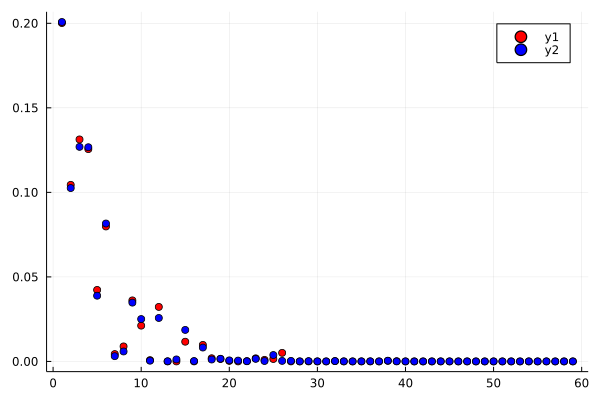

In [12]:
Plots.scatter(b_x; color="red", clim=(0, 1))
Plots.scatter!(b_y; color="blue", clim=(0, 1))

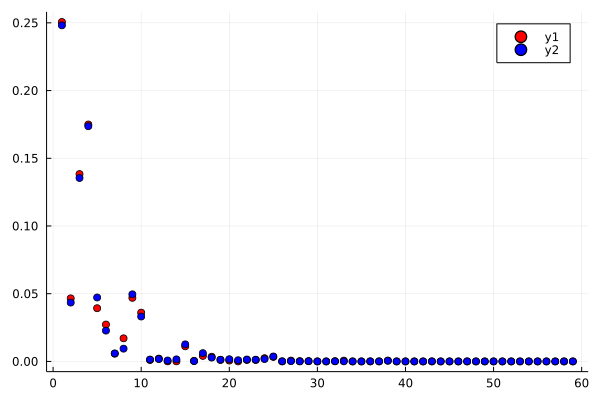

In [13]:
Plots.scatter(c_x; color="red", clim=(0, 1))
Plots.scatter!(c_y; color="blue", clim=(0, 1))

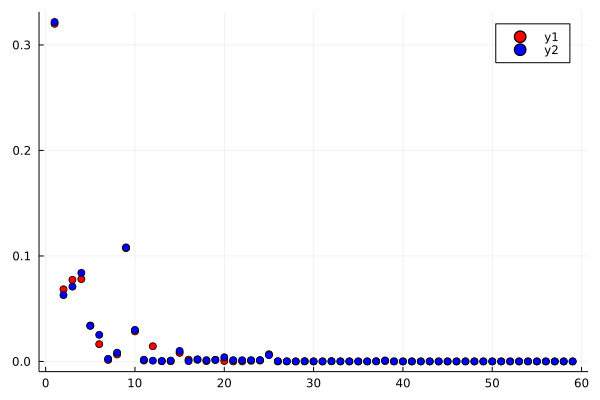

In [14]:
Plots.scatter(d_x; color="red", clim=(0, 1))
Plots.scatter!(d_y; color="blue", clim=(0, 1))

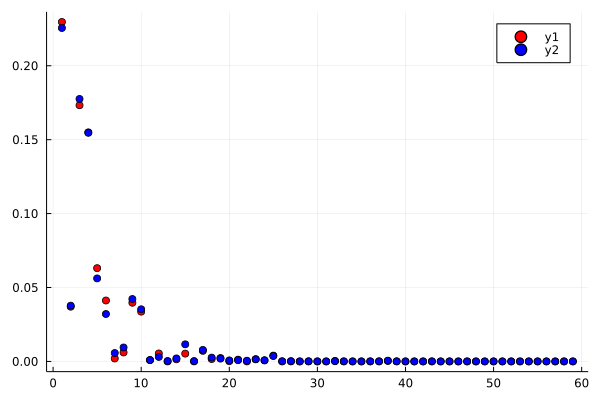

In [15]:
Plots.scatter(e_x; color="red", clim=(0, 1))
Plots.scatter!(e_y; color="blue", clim=(0, 1))

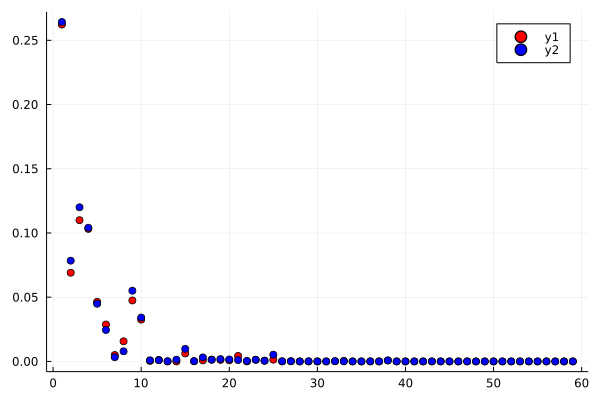

In [16]:
Plots.scatter(f_x; color="red", clim=(0, 1))
Plots.scatter!(f_y; color="blue", clim=(0, 1))